# Workshop - Data Science & Data Mining
###### NEREUS-USP, São Paulo, April 22, 2019


### Leonardo Caio de Ladalardo Martins*
lcladalardo@gmail.com

_*Undergraduate student at FEA-USP_

In [2]:
#Loading important libraries
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import time 
import numpy as np
import glob
from shapely.geometry import Point
import geopandas as gpd
import unidecode

Retrieving the already manipulated datasets:

In [3]:
#Loading the previous dataset:
data = pd.read_excel('C:/Users/lelec/Workshop NEREUS/dataset1.xlsx')
geo_data = pd.read_excel('C:/Users/lelec/Workshop NEREUS/dataset2.xlsx')

##  Section 4: Data Visualization - a Case Study: CNPJ Database

Now that we've done almost all dirty job, what about playing around with this amazing data? The objective of this section is to present an introduction to some interesting data visualization libraries. 

### Reminder: The dataset used as basis to this section will be exposed later for didactic purposes
Notice: the author suggests to read first section 5 (presented later for didactic purposes), for a better understanding of the capabilities, strengths and weaknessess of the approach used on this database. 

### The CNPJ Database:
This case study focuses on the CNPJ Public Database, available at [Receita Federal](http://receita.economia.gov.br/orientacao/tributaria/cadastros/cadastro-nacional-de-pessoas-juridicas-cnpj/dados-publicos-cnpj). This database is very rich in terms of details, but really heavy as well, it contains about:
1. 5gb of data (compressed) and almost 90gb of pure data (not compressed);
2. More than 140mn of rows of diferent layout tables;
3. Personal information about all firms (PJ) and partners (PF) in Brazil;
4. An impressive amount of geographic information about firms (but requiring to be cleaned as well);
5. Almost 70mn of entries overall formats;

In [4]:
data = data.drop(data.tail(1).index)

In [5]:
data['DATA'] = data['DATA'].astype(int)

## Section 4.1: General Descriptive Plots: an Introduction to Matplotlib

### Section 4.1.1: All-firms Plot

In [6]:
plt.rcParams.update({'font.size': 12})

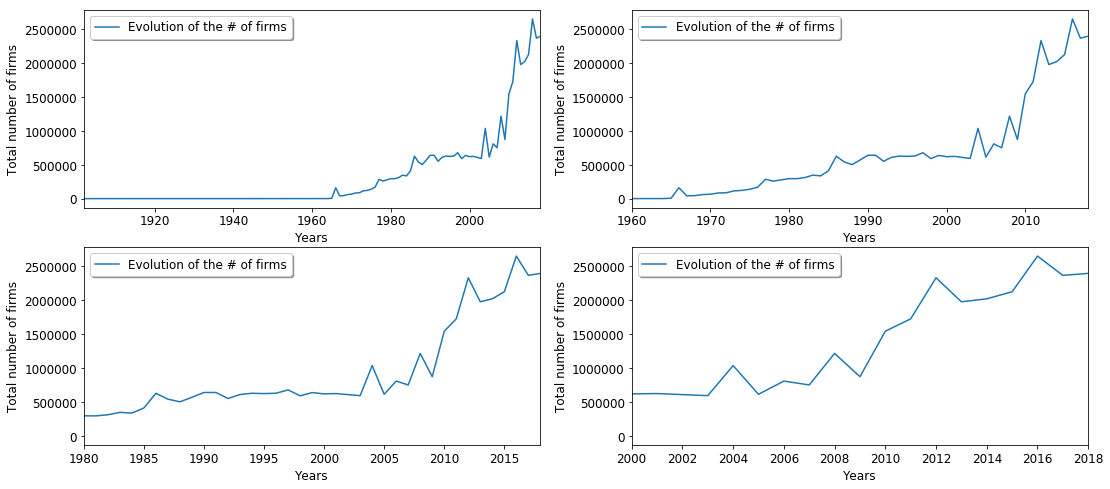

In [7]:
plt.figure(figsize=(18,8))
plots = {1:1902, 2:1960, 3:1980, 4:2000}
for i,v in plots.items():
    plt.subplot(2,2,i)
    plt.plot(data['DATA'],data['All'], label='Evolution of the # of firms')
    plt.xlabel('Years')
    plt.ylabel('Total number of firms')
    plt.xlim([v, 2018])
    plt.legend(shadow=True, fancybox=True, loc=2)

plt.show()

### Section 4.1.2: Median and Average Number of Firms Plot

In [8]:
data['Median'] = data.iloc[:,1:5290].median(axis=1)
data['Average'] = data.iloc[:,1:5290].mean(axis=1)

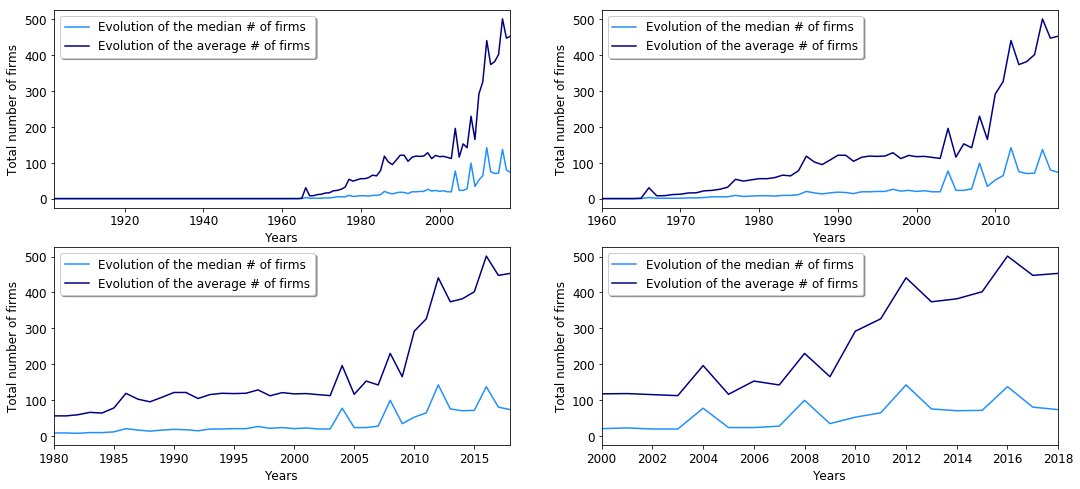

In [9]:
plt.figure(figsize=(18,8))
plots = {1:1902, 2:1960, 3:1980, 4:2000}
for i,v in plots.items():
    plt.subplot(2,2,i)
    plt.plot(data['DATA'],data['Median'], label='Evolution of the median # of firms', color='dodgerblue')
    plt.plot(data['DATA'],data['Average'], label='Evolution of the average # of firms', color = 'navy')
    plt.xlabel('Years')
    plt.ylabel('Total number of firms')
    plt.xlim([v, 2018])
    plt.legend(shadow=True, fancybox=True, loc=2)

plt.show()

### Section 4.1.3: Comparative Plots: Metropolitan Areas

In [10]:
rms = ['SAO PAULO', 'RIO DE JANEIRO', 'BELO HORIZONTE', 'BRASILIA',
       'PORTO ALEGRE', 'RECIFE', 'FORTALEZA', 'SALVADOR',
       'CURITIBA', 'CAMPINAS']
top = ['SAO PAULO', 'RIO DE JANEIRO', 'BELO HORIZONTE', 'CURITIBA']

In [11]:
data['rm_median'] = data[rms].quantile(0.5, axis = 1)
data['lower_bound'] = data[rms].quantile(0.2, axis = 1)
data['upper_bound'] = data[rms].quantile(0.8, axis = 1)

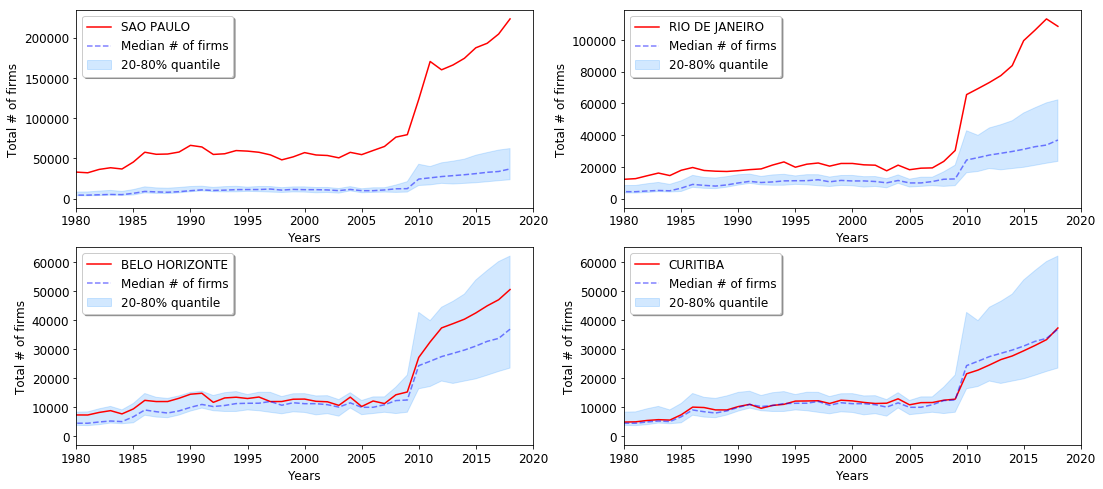

In [12]:
plt.figure(figsize=(18,8))
for i in range(len(top)):
    plt.subplot(2,2,i+1)
    plt.plot(data['DATA'],data[top[i]], label=top[i], color='red')
    plt.plot(data['DATA'],data['rm_median'], label='Median # of firms', 
             color = 'blue',linestyle='--', alpha=0.5 )
    plt.fill_between(data['DATA'],data['lower_bound'], data['upper_bound'], 
                     color = 'dodgerblue', alpha=0.2, label='20-80% quantile')
    plt.xlabel('Years')
    plt.ylabel('Total # of firms')
    plt.xlim([1980, 2020])
    plt.legend(shadow=True, fancybox=True, loc=2)

plt.show()

### Section 4.1.4: Comparative Plots: Metropolitan Areas (% of total)

In [13]:
data['total_rms'] = data[rms].sum(axis=1)

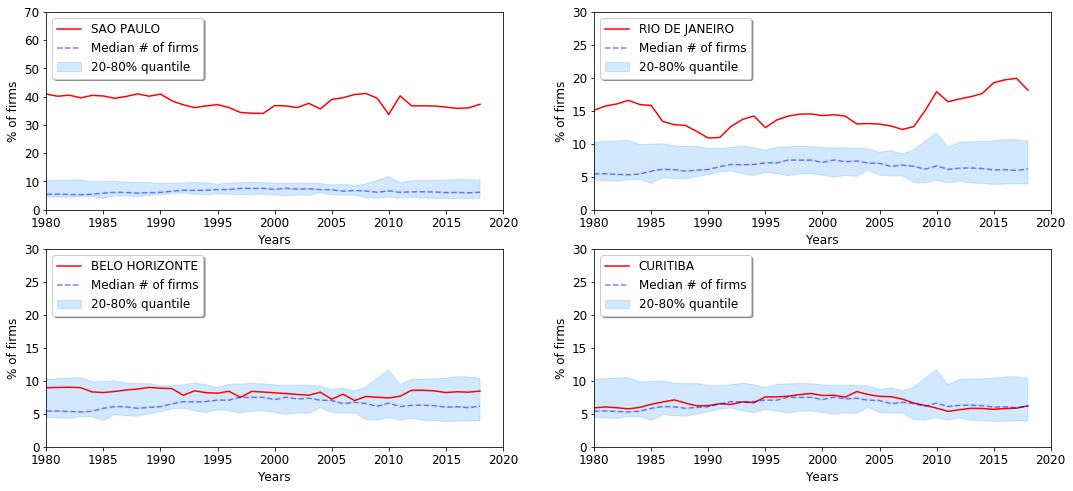

In [14]:
plt.figure(figsize=(18,8))
for i in range(len(top)):
    plt.subplot(2,2,i+1)
    plt.plot(data['DATA'],data[top[i]]/data['total_rms']*100, label=top[i], color='red')
    plt.plot(data['DATA'],data['rm_median']/data['total_rms']*100, label='Median # of firms', 
             color = 'blue',linestyle='--', alpha=0.5 )
    plt.fill_between(data['DATA'],data['lower_bound']/data['total_rms']*100, data['upper_bound']/data['total_rms']*100, 
                     color = 'dodgerblue', alpha=0.2, label='20-80% quantile')
    plt.xlabel('Years')
    plt.ylabel('% of firms')
    if i==0:
        plt.ylim([0, 70])
    else:
        plt.ylim([0, 30])
    plt.xlim([1980, 2020])
    plt.legend(shadow=True, fancybox=True, loc=2)

plt.show()

## Section 4.2: Geo-referenced Plots: an Introduction to GeoPandas

Over this section, we're going to work with GeoPandas, an interesting librarie in Python that allow us to deal with geospatial data together with also pre-manipulated DataFrames.

#### Geopandas:
"GeoPandas is an open source project to make working with geospatial data in python easier. GeoPandas extends the datatypes used by pandas to allow spatial operations on geometric types"

### Section 4.2.1: Plotting the General Number of Firms Using GeoPandas

The first step to follow while using GeoPandas is to manipulate the dataset in the following format:
    - rows: include the counties;
    - columns: include the variables of interest, such as frequency (# of firms), latitude and longitude;

In [15]:
geo = geo_data.groupby(by=['UF','MUNICIPIO', 'LATITUDE', 'LONGITUDE']).sum().groupby(level=[0]).cumsum()

In [16]:
geo.head()

Unnamed: 0    DATA  FREQ
UF MUNICIPIO    LATITUDE LONGITUDE                          
AC ACRELANDIA   -9.82    -66.88        5916176   71999  1193
   ASSIS BRASIL -10.94   -69.56       12277710  155892  1907
   BRASILEIA    -11.01   -68.74       18908949  263433  5113
   BUJARI       -9.83    -67.95       24539467  327498  5945
   CAPIXABA     -10.57   -67.67       30622661  403458  6828

Now that we've rearranjed the dataset, we need to transform it into a DataFrame object and also drop variables that we're not going to use anymore.

In [17]:
geo = pd.DataFrame(geo).drop(['DATA', 'Unnamed: 0'], axis = 1).reset_index()

In [18]:
geo.head()

,UF,MUNICIPIO,LATITUDE,LONGITUDE,FREQ
0,AC,ACRELANDIA,-9.82,-66.88,1193
1,AC,ASSIS BRASIL,-10.94,-69.56,1907
2,AC,BRASILEIA,-11.01,-68.74,5113
3,AC,BUJARI,-9.83,-67.95,5945
4,AC,CAPIXABA,-10.57,-67.67,6828


Now that we're rearrajed the dataset, we need to geo-reference it according to GeoPandas [documentation](http://geopandas.org/gallery/create_geopandas_from_pandas.html#sphx-glr-gallery-create-geopandas-from-pandas-py). Notice that we'll create an GeoDataFrame object, that contains a tuple with the coordinates of each county. Now we're going to apply the function 'Point' that creates the geo-locational position of each county.

In [19]:
geo['Coordinates'] = list(zip(geo.LONGITUDE, geo.LATITUDE))
geo['Coordinates'] = geo['Coordinates'].apply(Point)

Last but not least, we create the GeoDataFrame object as it follows:

In [20]:
gdf = gpd.GeoDataFrame(geo, geometry='Coordinates')

In [21]:
gdf.head()

,UF,MUNICIPIO,LATITUDE,LONGITUDE,FREQ,Coordinates
0,AC,ACRELANDIA,-9.82,-66.88,1193,POINT (-66.88 -9.82)
1,AC,ASSIS BRASIL,-10.94,-69.56,1907,POINT (-69.56 -10.94)
2,AC,BRASILEIA,-11.01,-68.74,5113,POINT (-68.73999999999999 -11.01)
3,AC,BUJARI,-9.83,-67.95,5945,POINT (-67.95 -9.83)
4,AC,CAPIXABA,-10.57,-67.67,6828,POINT (-67.67 -10.57)


### Loading Brazil's ShapeFile - NEREUS

The most interesting functionality in GeoPandas is that it allows us to load ShapeFiles and make plots using them as reference. As an example, we've extracted Brazil's ShapeFiles at NEREUS Website, that you can find it [here](http://www.usp.br/nereus/?dados=brasil).

In [22]:
map_regions = gpd.read_file('C:/Users/lelec/Workshop NEREUS/UFEBRASIL.shp')
map_counties = gpd.read_file('C:/Users/lelec/Workshop NEREUS/MIEBRASIL.shp')

Notice that it will load the ShapeFile as a GeoDataFrame object:

In [23]:
map_regions.head()

,ID,CD_GEOCODU,NM_ESTADO,NM_REGIAO,geometry
0,1,11,RONDÔNIA,NORTE,POLYGON ((-63.32720817710297 -7.97672029856090...
1,2,12,ACRE,NORTE,POLYGON ((-73.18252539408964 -7.33549646405647...
2,3,13,AMAZONAS,NORTE,POLYGON ((-67.32608847052387 2.029713905653285...
3,4,14,RORAIMA,NORTE,POLYGON ((-60.20050657607426 5.264343437578056...
4,5,15,PARÁ,NORTE,(POLYGON ((-54.95430669626876 2.58369242339712...


### Geo-referencing the firms according to it's size 

In [24]:
#Linear normalization of firms frequency in each county
norm = (gdf['FREQ'] - np.min(gdf['FREQ']))/(np.max(gdf['FREQ'] - np.min(gdf['FREQ'])))

### Total # of firms per region and state from 1902-2018 

<Figure size 1296x1296 with 0 Axes>

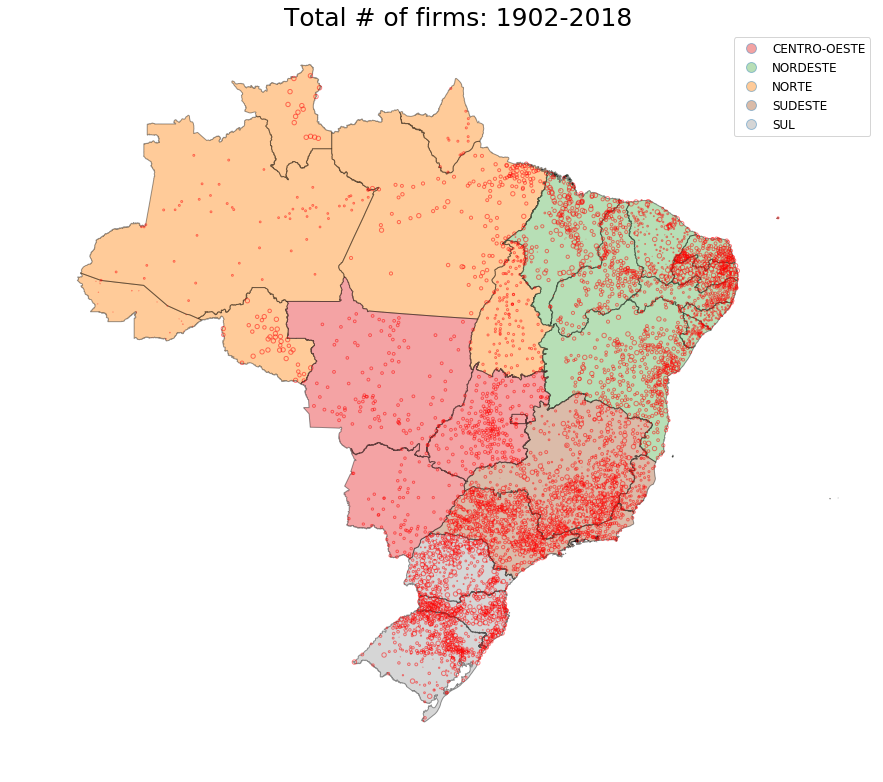

<Figure size 1296x1296 with 0 Axes>

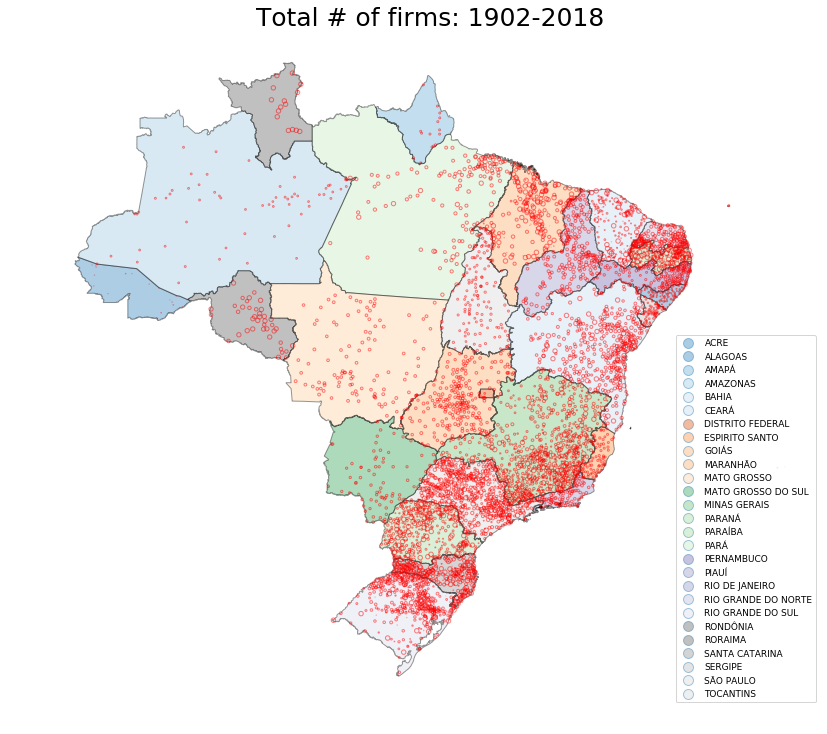

In [146]:
#First Plot
plt.figure(figsize=(18,18))
ax1 = map_regions.plot(column='NM_REGIAO', categorical=True, alpha=0.4, edgecolor='black',
                       figsize=(15, 15), cmap = 'Set1', legend=True)
ax1.scatter(gdf['LONGITUDE'], gdf['LATITUDE'], c='None', alpha=0.5, s=norm*20, edgecolors='red')
ax1.axis('off')
ax1.set_title('Total # of firms: 1902-2018', fontdict={'fontsize': '25', 'fontweight' : '3'})
plt.show()
#Second Plot
plt.figure(figsize=(18,18))
ax2 = map_regions.plot(column='NM_ESTADO', categorical=True, alpha=0.4, edgecolor='black',
                       figsize=(14, 14), cmap = 'tab20c', legend = True, legend_kwds={'loc': 'lower right', 'fontsize': '9'})
ax2.scatter(gdf['LONGITUDE'], gdf['LATITUDE'], c='None', alpha=0.5, s=norm*20, edgecolors='red')
ax2.axis('off')
ax2.set_title('Total # of firms: 1902-2018', fontdict={'fontsize': '25', 'fontweight' : '3'})
plt.show()

### Section 4.2.2: Comparing the Evolution of the Number of Firms Using GeoPandas

What if we would like to compare the evolution of the number of firms? We would need to create one algorithm to manipulate our dataset aggregating the series as we would like. 

In [26]:
# Step 4: manipulate your dataset using pandas' functionalities
class geodata_visualization:
    def __init__(self, df):
        self.df = df
      
    def pivot(self, ind, col, val):
        self.ind = ind
        self.col = col
        self.val = val
        self.pivot = self.df.pivot_table(index = self.ind, columns = self.col, 
                                         values = self.val, aggfunc = 'sum', margins = False)
        self.pivot = self.pivot.fillna(0)
        return self.pivot

In [27]:
#Initializing the algorithm
geo_init = geodata_visualization(geo_data)

In [28]:
#Transforming the dataset to GeoDataFrame format
geo_df = geo_init.pivot(['UF','MUNICIPIO', 'LATITUDE', 'LONGITUDE'], 'DATA', 'FREQ')

In [29]:
#Converting the pivot table into a dataframe and dropping usuless variables
geo_df = pd.DataFrame(geo_df).reset_index()
geo_df = geo_df.drop(geo_df.columns[[4,5,6,7,8]], axis=1)

In [30]:
#Defininf a list creator function to help us to cummulate values as we would like
def cum_aux(y0,yf):
    l = []
    for i in range(y0,yf+1):
        l.append(i)
    return l
geo_df["cum_1960"] = geo_df[cum_aux(1902,1960)].sum(axis = 1)
geo_df["cum_1980"] = geo_df[cum_aux(1960,1980)].sum(axis = 1)
geo_df["cum_2000"] = geo_df[cum_aux(1980,2000)].sum(axis = 1)
geo_df["cum_2018"] = geo_df[cum_aux(2000,2018)].sum(axis = 1)

The same process used before needs to be done now: Geopandas will require a geo-cordinated specific format to plot the maps. To do this, we transform the locational variables to the required format.

In [31]:
geo_df['Coordinates'] = list(zip(geo.LONGITUDE, geo.LATITUDE))
geo_df['Coordinates'] = geo['Coordinates'].apply(Point)
gdf_new = gpd.GeoDataFrame(geo_df, geometry='Coordinates')

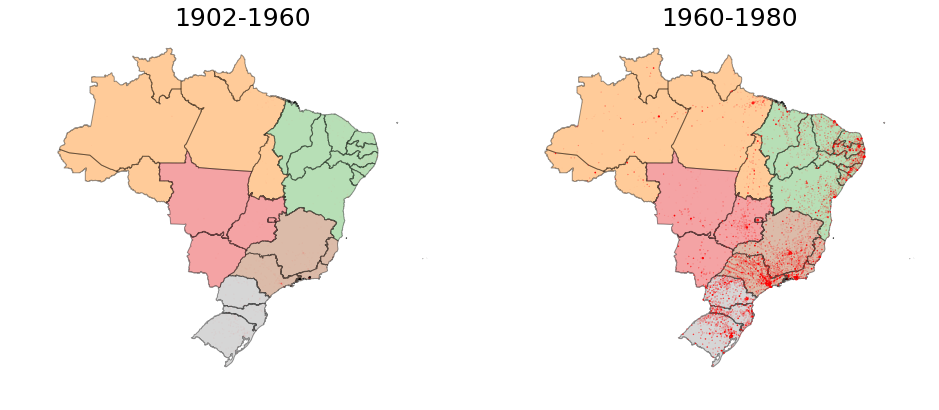

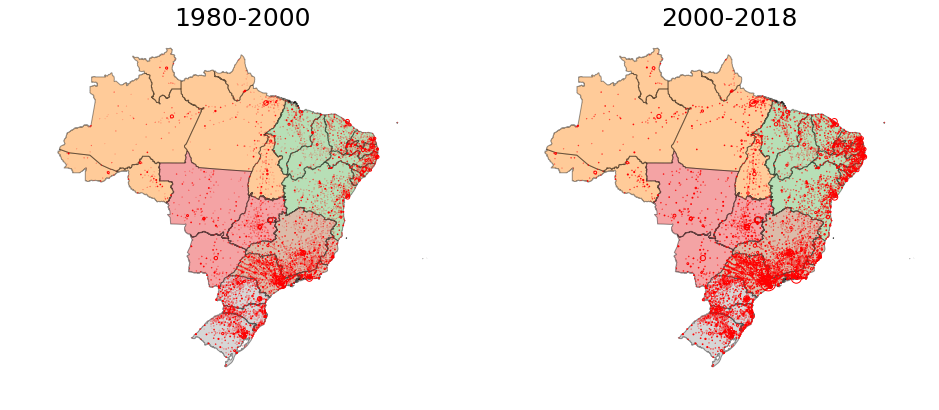

In [145]:
#First sequence of subplots
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,16))
#First Plot
ax1 = map_regions.plot(ax=ax1, column='NM_REGIAO', categorical=True, alpha=0.4, edgecolor='black',figsize=(15, 15), 
                       cmap = 'Set1')
ax1.scatter(geo_df['LONGITUDE'], geo_df['LATITUDE'], c='None', alpha=1, s=geo_df["cum_1960"]/10**4, edgecolors='red')
ax1.axis('off')
ax1.set_title('1902-1960', fontdict={'fontsize': '25', 'fontweight' : '3'})
#Second Plot
ax2 = map_regions.plot(ax=ax2, column='NM_REGIAO', categorical=True, alpha=0.4, edgecolor='black',figsize=(15, 15), 
                       cmap = 'Set1')
ax2.scatter(geo_df['LONGITUDE'], geo_df['LATITUDE'], c='None', alpha=1, s=geo_df["cum_1980"]/10**4, edgecolors='red')
ax2.axis('off')
ax2.set_title('1960-1980', fontdict={'fontsize': '25', 'fontweight' : '3'})

#Second sequence of subplots
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,16))
#First Plot
ax1 = map_regions.plot(ax=ax1, column='NM_REGIAO', categorical=True, alpha=0.4, edgecolor='black',figsize=(15, 15), 
                       cmap = 'Set1')
ax1.scatter(geo_df['LONGITUDE'], geo_df['LATITUDE'], c='None', alpha=1, s=geo_df["cum_2000"]/10**4, edgecolors='red')
ax1.axis('off')
ax1.set_title('1980-2000', fontdict={'fontsize': '25', 'fontweight' : '3'})
#Second Plot
ax2 = map_regions.plot(ax=ax2, column='NM_REGIAO', categorical=True, alpha=0.4, edgecolor='black',figsize=(15, 15), 
                       cmap = 'Set1')
ax2.scatter(geo_df['LONGITUDE'], geo_df['LATITUDE'], c='None', alpha=1, s=geo_df["cum_2018"]/10**4, edgecolors='red')
ax2.axis('off')
ax2.set_title('2000-2018', fontdict={'fontsize': '25', 'fontweight' : '3'})

plt.show()

## Section 4.3: Chloropletic Maps: São Paulo # of Firms

What if we would like to make a chloropletic plot of São Paulo? How we can write a code to allow us to visualiza firm's concentration in São Paulo?

Our first task is to create a sub-dataset only for São Paulo:

In [150]:
# Creating a sub-dataset containing only SP data
gdf_sp = gdf[gdf['UF'] == 'SP']

In [152]:
gdf_sp.head()

,UF,MUNICIPIO,LATITUDE,LONGITUDE,FREQ,Coordinates
4656,SP,ADAMANTINA,-21.68,-51.07,11437,POINT (-51.07 -21.68)
4657,SP,ADOLFO,-21.23,-49.64,12810,POINT (-49.64 -21.23)
4658,SP,AGUAI,-22.05,-46.97,21486,POINT (-46.97 -22.05)
4659,SP,AGUAS DA PRATA,-21.93,-46.71,23922,POINT (-46.71 -21.93)
4660,SP,AGUAS DE LINDOIA,-22.47,-46.63,30446,POINT (-46.63 -22.47)


Then, we will need to load SP counties shapefile, disposable at NEREUS website:

In [151]:
# Loading SP counties shapefile
map_sp = gpd.read_file('C:/Users/lelec/Workshop NEREUS/35MUE250GC_SIR.shp')

In [153]:
map_sp.head()

,ID,CD_GEOCODM,NM_MUNICIP,geometry
0,1727,3500105,ADAMANTINA,POLYGON ((-51.09093440178869 -21.4721443534013...
1,1728,3500204,ADOLFO,POLYGON ((-49.69668476194749 -21.3443048706382...
2,1729,3500303,AGUAÍ,POLYGON ((-47.01253820142389 -22.0052740205695...
3,1730,3500402,ÁGUAS DA PRATA,POLYGON ((-46.73068599999999 -21.9447039999999...
4,1731,3500501,ÁGUAS DE LINDÓIA,POLYGON ((-46.63499786230679 -22.4578139112719...


Important: we will need to merge both firms dataset and shapefile dataset together. This will require some data manipulation, as ShapeFile dataset contains accents on words, which will need to be correctly treated. 

In [154]:
# Removing the accents of 'NM_MUNICIP' column in map_sp data
def decoder(df):
    for i in range(len(df)):
        df[i] = unidecode.unidecode(df[i])

In [86]:
decoder(map_sp['NM_MUNICIP'])

C:\Users\lelec\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Now, we can correctly merge both datasets together:

In [87]:
geo_sp = pd.merge(map_sp, gdf_sp, how='left', left_on='NM_MUNICIP',right_on='MUNICIPIO')

In [157]:
geo_sp.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 645 entries, 0 to 644
Data columns (total 10 columns):
ID             645 non-null int64
CD_GEOCODM     645 non-null object
NM_MUNICIP     645 non-null object
geometry       645 non-null object
UF             628 non-null object
MUNICIPIO      628 non-null object
LATITUDE       628 non-null float64
LONGITUDE      628 non-null float64
FREQ           645 non-null float64
Coordinates    628 non-null object
dtypes: float64(3), int64(1), object(6)
memory usage: 55.4+ KB


Notice that we have some missing values in 'FREQ' column. In practice we would need to understand why those values are missing. However, for explanation only, we've set arbitrary the number of firms on those counties as zero.

In [136]:
geo_sp['FREQ'] = geo_sp['FREQ'].fillna(value=0)

### Chloropletic Plot of São Paulo

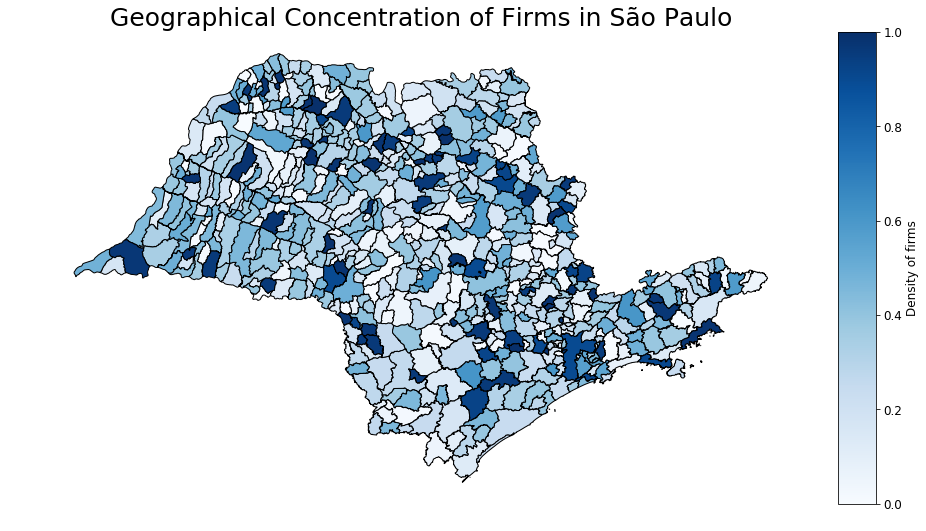

In [149]:
# Auxiliary library to match the colorbar with the map
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Normalized:
norm = (geo_sp['FREQ'] - np.min(geo_sp['FREQ']))/(np.max(geo_sp['FREQ'])-np.min(geo_sp['FREQ']))

fig, ax = plt.subplots(1, figsize=(15, 15))
geo_sp.plot(ax=ax, column=(geo_sp['FREQ'] - np.min(geo_sp['FREQ']))/(np.max(geo_sp['FREQ'])-np.min(geo_sp['FREQ']))
            ,alpha=1, edgecolor='black',
                       figsize=(15, 15), cmap = 'Blues')
ax.set_title('Geographical Concentration of Firms in São Paulo', fontdict={'fontsize': '25', 'fontweight' : '3'})
#Second Plot
ax.axis('off')
# Auxiliary function to plot a scaled colorbar:
norm = (geo_sp['FREQ'] - np.min(geo_sp['FREQ']))/(np.max(geo_sp['FREQ'])-np.min(geo_sp['FREQ']))

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=np.min(norm), vmax=np.max(norm)))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)
cbar = fig.colorbar(sm, cax=cax)
cbar.ax.set_ylabel('Density of firms')
plt.show()